<a href="https://colab.research.google.com/github/Yakobo-ky/ML-II-2019/blob/master/kwetu_pazuri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (2.11.0)


In [ ]:
!pip install simpletransformers

In [ ]:
!pip install gputil

In [ ]:
!pip install psutil

In [ ]:
!pip install humanize

In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.6 GB  |     Proc size: 5.6 GB
GPU RAM Free: 411MB | Used: 15869MB | Util  97% | Total     16280MB


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
import re
import random
import torch
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

In [ ]:
#Loading the data
train = pd.read_csv("/content/Train.csv")
test = pd.read_csv("/content/Test.csv")
Sample = pd.read_csv("/content/SampleSubmission.csv")
var = pd.read_csv("/content/VariableDefinitions.csv")

In [ ]:
train.head()

,id,content,category
0,SW0,"SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa ...",Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huo.Mwanri ameagiza kuwa, hata kama kuna likizo zim...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote za umma ambazo hazitumii mfumo wa GePG katika ukusanyaji wa fedha kufanya hivyo na baada ya hapo itafanya ukaguzi na kuwawajibisha maofi sa masuhuli wa...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet imeingia makubaliano ya udhamini na timu ya soka ya Manispaa ya Kinondoni (KMC) kwa miaka mitano wenye thamani ya sh Bilioni 1.Akizungumzia udhamini huo ...,michezo
4,SW1000,"WATANZANIA wamekumbushwa kusherehekea sikukuu ya Krismasi kwa kuenzi amani, umoja na kulinda tamaduni za nchi ili kupambana na changamoto mbalimbali zinazojitokeza, ikiwemo vitendo vya ushoga na ...",Kitaifa


In [ ]:
train.tail()

,id,content,category
5146,SW993,"RAIS John Magufuli ameendelea kung’ara katika siasa za kimataifa mwaka huu, baada ya Taasisi ya Transparency International (TI), kuitaja Tanzania kuwa moja ya nchi zilizofanya vizuri katika masua...",Kitaifa
5147,SW994,"KAMPENI inayohimiza watafi ti kuandika upya historia ya ukombozi wa nchi na Afrika kwa ujumla imeanza, lengo likiwa ni kuwezesha wanafunzi kusoma historia ambayo haijapotoshwa kwa makusudi.Akiwas...",Kitaifa
5148,SW996,"MATUKIO mapya ya malaria kwa kila watu 1,000 katika jamii, yamepungua kwa asilimia 62 kutoka matukio 295 kwa kila watu 1,000 mwaka 2008 hadi matukio 112 kwa kila watu 1,000 .Hiyo ni kwa mujibu wa...",Kitaifa
5149,SW997,IMEELEZWA kuwa hakuna sheria yoyote inayokataza taarifa za Tume ya Haki za Binadamu na Utawala Bora kujadiliwa Bungeni endapo mbunge ataona kuna jambo la kuibua kutoka kwenye taarifa iliyoibuliwa...,Kitaifa
5150,SW999,"Akizungumza mara baada ya kutiwa saini kwa makubaliano hayo jana jioni Waziri wa Nchi Ofisi ya Waziri Mkuu Tawala za Mikoa na Serikali za Mitaa, Hawa Ghasia, alisema uwekezaji huo unatarajiwa kul...",Biashara


In [ ]:
Sample.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,0,0


In [ ]:
Sample['burudani'].value_counts()

0    1288
Name: burudani, dtype: int64

In [ ]:
train.isnull().any()

id          False
content     False
category    False
dtype: bool

In [ ]:
test.isnull().any()

swahili_id    False
content       False
dtype: bool

In [ ]:
train.shape, test.shape

((5151, 3), (1288, 2))

In [ ]:
train.category.value_counts()

Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64

In [ ]:
# extracting the number of examples of each class
Kitaifa_len = train[train['category'] == 'Kitaifa'].shape[0]
Biashara_len = train[train['category'] == 'Biashara'].shape[0]
michezo_len = train[train['category'] == 'michezo'].shape[0]
Kimataifa_len = train[train['category'] == 'Kimataifa'].shape[0]
Burudani_len = train[train['category'] == 'Burudani'].shape[0]

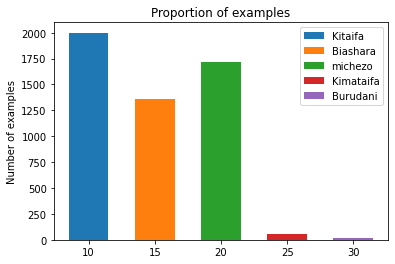

In [ ]:
# bar plot of the 3 classes
plt.bar(10,Kitaifa_len,3, label="Kitaifa")
plt.bar(15,Biashara_len,3, label="Biashara")
plt.bar(20,michezo_len,3, label="michezo")
plt.bar(25,Kimataifa_len,3, label="Kimataifa")
plt.bar(30,Burudani_len,3, label="Burudani")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [ ]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
train['content'] = train['content'].apply(remove_punctuation)
train.head(10)

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani kabila au itikadi yoyoteHayo yalisemwa na...,Kitaifa
1,SW1,Mkuu wa Mkoa wa Tabora Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huoMwanri ameagiza kuwa hata kama kuna likizo zimeid...,Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote za umma ambazo hazitumii mfumo wa GePG katika ukusanyaji wa fedha kufanya hivyo na baada ya hapo itafanya ukaguzi na kuwawajibisha maofi sa masuhuli wa...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya Mbet imeingia makubaliano ya udhamini na timu ya soka ya Manispaa ya Kinondoni KMC kwa miaka mitano wenye thamani ya sh Bilioni 1Akizungumzia udhamini huo jana...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu ya Krismasi kwa kuenzi amani umoja na kulinda tamaduni za nchi ili kupambana na changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga na ma...,Kitaifa
5,SW1002,Malkia wa Mipasho Afrika Mashariki Khadija Omary Kopa amesema wasanii nchini hawana umoja na kwamba wale wa bongo fleva na watu wengine wanawaona wa taarabu ni watu wa hali ya chini na masikiniAm...,michezo
6,SW1003,Meneja Masoko na Mawasiliano wa taasisi hiyo Ngula Cheyo aliyasema hayo jana ikiwa ni siku chache baada ya kuzinduliwa kwa huduma ya mikopo ya viwanja jijini Dar es Salaam huku akisisitiza kwamba...,Biashara
7,SW1004,IDADI ya vifo vya waendesha bodaboda nchini vitokanavyo na ajali imepungua katika kipindi cha robo ya kwanza ya mwaka huu kinachoanzia Januari hadi Machi ikilinganishwa na idadi ya vifo vya bodab...,Kitaifa
8,SW1006,Katika uzinduzi huo rais amesema kuna haja ya kutafuta majawabu kuhusu namna ya kuongeza maghala ya kuhifadhia mazao kwani kadiri kilimo kinavyoboreshwa mazao yanayozalishwa yanakosa pa kuhifadhi...,Biashara
9,SW1007,Mshindi wa mchezo utakaozikutanisha Tottenham huko Rochdale jana atakutana na Sheffield Jumatano au Swansea ambaye atacheza baada ya suluhu ya jana JumamosiSouthampton leo itasafiri na kucheza na...,michezo


In [ ]:
test['content'] = test['content'].apply(remove_punctuation)
test.head(10)

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,MKUU wa Wilaya ya Bahi Mkoani Dodoma Mwanahamisi Munkunda ameuagiza uongozi wa halmashauri ya wilaya hiyo na kamati zote za usimaminzi wa ujenzi wa mradi wa hospitali yao kukamilisha ujenzi Mei 3...
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,MWISHONI mwa wiki hii Timu ya Soka ya Taifa Taifa Stars itakuwa na kibarua kizito dhidi ya Sudan katika mechi ya kuwania kufuzu Fainali za Michuano ya Afrika kwa wachezaji wa ndani ChanKatika har...
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Mashariki katika Umoja wa Ulaya EU yameongezeka hadi Dola za Marekani bilioni 25 Sh trilioni 52 za Tanzania mwaka 2017 sawa na ongezeko la asilimia naneTaarif...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGPAHI amefariki dunia gafla baada ya kuanguka akiwa katika shughuli zake za kikazi huko Kahama Shinyanga leo AGPAHI ni asasi ya kiraia inayojishughulish...
4,00a5cb12d3058dcf2e42f277eee599992db32412,WAZIRI wa Kilimo Japhet Hasunga amesema serikali inajenga kiwanda cha kuchakata mazao ya korosho mabibo ili kuzalisha kutengeneza juisi na mvinyo Naliendele MtwaraWaziri Hasunga alitoa kauli hiyo...
5,00a93e174866089d7f4b59b72645573f963da555,Mkufunzi mpya wa Tottenham Jose Mourinho atajaribu kumsajili tena mshambuliaji wa zamani wa Spurs Gareth Bale 30 kutoka Real Madrid AS in Spanish Mourinho pia anamlenga kiungo wa kati wa Sportin...
6,00caee8b79f36cc0a5ae4fe86b8abbedeef6c705,Mwenyekiti wa Chama Cha Mapinduzi CCM Taifa Rais John Magufuli amekipongeza chama hicho kwa kutimiza miaka 43 tangu kuzaliwa kwakeKatika salamu zake kupitia mtandao wa kijamii wa Twitter Rais Mag...
7,00e72e69de296484ccacd96e38240844ac61be23,NYOTA wa uigizaji na muziki Esha Buheti Steven ‘Nyerere’ Mengele na Hamis Mwinjuma ‘Mwana FA’ wamezungumzia umuhimu wa mashabiki wa michezo kumuunga mkono bondia Hassan Mwakinyo kwa kujitokeza kw...
8,018effc3b6ce812c825fb01d244f4b849658ef3c,WAKATI vinara wa Ligi Kuu Tanzania Bara wakionesha udhaifu katika mchezo wao dhidi ya Mtibwa Sugar kwa kufungwa 10 watani zao Simba wameendelea kula viporo’ vyao vizuri baada ya jana kushinda 21 ...
9,01996c3787dbce345ac122a8912dc9ab57334e2e,Idris ameandika kwenye ukurasa wake wa Instagram akimkumbusha Diamond kutekeleza ahadi yake kumpigia Zari magoti kumuomba msamaha kama alivyowahi kueleza awaliIdris ameandika Wabongo wanafiki san...


In [ ]:
import nltk
nltk.download("popular")
stopwords = nltk.corpus.stopwords.words('english')
new_words=('wewe','mimi', 'haikuwa', 'twende', 'ni', 'ya', 'kule', 'wa', 'wake', 'kwenye', 'na', 'mwa', 'hii', 'za', 'esha', 'ti',
          'katika', 'la', 'huo', 'jana', 'wiki')
for i in new_words:
    stopwords.append(i)
print(stopwords)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [ ]:
import re

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = stopwords

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
train['content'] = train['content'].apply(clean_text)
test['content'] = test['content'].apply(clean_text)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(train['content'])
count_vectorizer.fit(test['content'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

In [ ]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

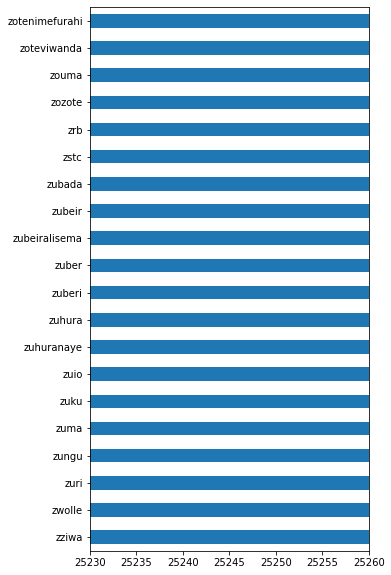

In [ ]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (25230, 25260))

In [ ]:
#One Hot encoding conversion
traindummy = pd.get_dummies(train, prefix_sep = "_", columns = ['category'])

In [ ]:
traindummy.head()

,id,content,category_Biashara,category_Burudani,category_Kimataifa,category_Kitaifa,category_michezo
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0,0,0,1,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,1,0,0,0,0
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0,0,0,1,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0,0,0,0,1
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0,0,0,1,0


In [ ]:
traindummy['category_Burudani'].value_counts()

0    5134
1      17
Name: category_Burudani, dtype: int64

In [ ]:
train_biashara = traindummy.drop(['category_Burudani', 'category_Kimataifa', 'category_Kitaifa', 'category_michezo'], axis = 1)

In [ ]:
train_biashara.head()

,id,content,category_Biashara
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,1
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0


In [ ]:
train_kimataifa = traindummy.drop(['category_Biashara', 'category_Burudani', 'category_Kitaifa', 'category_michezo'], axis = 1)

In [ ]:
train_kimataifa.head()

,id,content,category_Kimataifa
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,0
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0


In [ ]:
train_burudani = traindummy.drop(['category_Biashara', 'category_Kimataifa', 'category_Kitaifa', 'category_michezo'], axis = 1)

In [ ]:
train_burudani.head()

,id,content,category_Burudani
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,0
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0


In [ ]:
train_Kitaifa = traindummy.drop(['category_Biashara', 'category_Burudani', 'category_Kimataifa', 'category_michezo'], axis = 1)

In [ ]:
train_Kitaifa.head()

,id,content,category_Kitaifa
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,1
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,0
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,1
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,1


In [ ]:
train_michezo = traindummy.drop(['category_Biashara', 'category_Burudani', 'category_Kimataifa', 'category_Kitaifa'], axis = 1)

In [ ]:
train_michezo.head()

,id,content,category_michezo
0,SW0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0
1,SW1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,0
2,SW10,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0
3,SW100,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,1
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0


### Start with training biashara with roberta large

In [ ]:
train1=train_biashara.drop(['id'], axis=1)
test1=test.drop(['swahili_id'], axis=1)
test1['label']=0

In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
i=1
for train_index, test_index in fold.split(train1, train1['category_Biashara']):
    train1_trn, train1_val = train1.iloc[train_index], train1.iloc[test_index]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train1_trn)
    raw_outputs_val = model.eval_model(train1_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train1_val['category_Biashara'], raw_outputs_val)}")
    err.append(log_loss(train1_val['category_Biashara'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test1)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
final=pd.DataFrame()
final['swahili_id']=test['swahili_id']
final['biashara']=np.mean(y_pred_tot, 0)
print(final.shape)
final.to_csv('biashara_preds.csv',index=False)


Log_Loss: 0.5767623659714248
Log_Loss: 0.5770222564307295
Log_Loss: 0.26101896785517303
Log_Loss: 0.576369909699573
Log_Loss: 0.47743105434978655
Log_Loss: 0.576959469983744
Log_Loss: 0.44939513438085255
Log_Loss: 0.5807648536770843
Log_Loss: 0.5768511744663697
Log_Loss: 0.5768328810385032
Log_Loss: 0.5767520020405451
Log_Loss: 0.30808725438881596
Log_Loss: 0.27680042139635014
Log_Loss: 0.5785078938601081
Log_Loss: 0.5730651158998913
Log_Loss: 0.2925311260302243
Log_Loss: 0.5778057475498214
Log_Loss: 0.5784902987777027
Log_Loss: 0.5777975825252236
Log_Loss: 0.33319532574817595
Mean LogLoss:  0.49512204180350505
(1288, 2)
CPU times: user 54min 45s, sys: 26min 50s, total: 1h 21min 35s
Wall time: 1h 30min 19s


### Training Kimataifa with roberta large

In [ ]:
#train_kimataifa, category_Kimataifa

In [ ]:
train2=train_kimataifa.drop(['id'], axis=1)
test2=test.drop(['swahili_id'], axis=1)
test2['label']=0

In [ ]:
train2.head()

,content,category_Kimataifa
0,serikali imesema haitakuwa tayari kuona amani utulivu nchi inachezewa huku ikisisitiza uwepo umoja kati wananchi bila kujali tofauti imani kabila au itikadi yoyotehayo yalisemwa naibu waziri mambo...,0
1,mkuu mkoa tabora aggrey mwanri amesitisha likizo viongozi wote mkoani humo kutekeleza maazimio jukwaa fursa biashara mkoa huomwanri ameagiza kuwa hata kama kuna likizo zimeidhinishwa zifutweamemua...,0
2,serikali imetoa miezi sita kwa taasisi zote umma ambazo hazitumii mfumo gepg ukusanyaji fedha kufanya hivyo baada hapo itafanya ukaguzi kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo...,0
3,kampuni mchezo kubahatisha mbet imeingia makubaliano udhamini timu soka manispaa kinondoni kmc kwa miaka mitano wenye thamani sh bilioni 1akizungumzia udhamini baada kusaini mkataba meneja masoko ...,0
4,watanzania wamekumbushwa kusherehekea sikukuu krismasi kwa kuenzi amani umoja kulinda tamaduni nchi ili kupambana changamoto mbalimbali zinazojitokeza ikiwemo vitendo vya ushoga matumizi dawa kule...,0


In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
i=1
for train_index1, test_index1 in fold.split(train2, train2['category_Kimataifa']):
    train2_trn, train2_val = train2.iloc[train_index1], train2.iloc[test_index1]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train2_trn)
    raw_outputs_val = model.eval_model(train2_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train2_val['category_Kimataifa'], raw_outputs_val)}")
    err.append(log_loss(train2_val['category_Kimataifa'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test2)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
final=pd.DataFrame()
final['swahili_id']=test['swahili_id']
final['kimataifa']=np.mean(y_pred_tot, 0)
print(final.shape)
final.to_csv('kimataifa_preds.csv',index=False)

Log_Loss: 0.0635292372348639
Log_Loss: 0.0678891029494071
Log_Loss: 0.06336746421866407
Log_Loss: 0.06531151956625918
Log_Loss: 0.06451712837153974
Log_Loss: 0.0657673820856843
Log_Loss: 0.06380800684812919
Log_Loss: 0.06494375444631013
Log_Loss: 0.06370043145969163
Log_Loss: 0.06619558178516495
Log_Loss: 0.0635627257175628
Log_Loss: 0.04554051222960947
Log_Loss: 0.04610071842584049
Log_Loss: 0.045542929459232766
Log_Loss: 0.045681125828670156
Log_Loss: 0.045816225188164625
Log_Loss: 0.045860269067062476
Log_Loss: 0.06524163368792212
Log_Loss: 0.06509715645186284
Log_Loss: 0.0637556912616649
Mean LogLoss:  0.059061429814165324
(1288, 2)
CPU times: user 54min 11s, sys: 26min 47s, total: 1h 20min 58s
Wall time: 1h 28min 48s


In [ ]:
train3=train_burudani.drop(['id'], axis=1)
test3=test.drop(['swahili_id'], axis=1)
test3['label'] = 0

In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
i=1
for train_index2, test_index2 in fold.split(train3, train3['category_Burudani']):
    train3_trn, train3_val = train3.iloc[train_index2], train3.iloc[test_index2]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True, num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train3_trn)
    raw_outputs_val = model.eval_model(train3_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train3_val['category_Burudani'], raw_outputs_val)}")
    err.append(f1_score(train3_val['category_Burudani'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test3)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
final=pd.DataFrame()
final['swahili_id']=test['swahili_id']
final['burudani']=(y_pred_tot, 0)
print(final.shape)
final.to_csv('burudani_preds.csv',index=False)

Log_Loss: 0.026066856707857793


ValueError: ignored

Since the 

In [ ]:
train4=train_Kitaifa.drop(['id'], axis=1)
test4=test.drop(['swahili_id'], axis=1)
test4['label']=0

In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
i=1
for train_index3, test_index3 in fold.split(train4, train4['category_Kitaifa']):
    train4_trn, train4_val = train4.iloc[train_index3], train4.iloc[test_index3]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train4_trn)
    raw_outputs_val = model.eval_model(train4_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train4_val['category_Kitaifa'], raw_outputs_val)}")
    err.append(log_loss(train4_val['category_Kitaifa'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test4)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
final=pd.DataFrame()
final['swahili_id']=test['swahili_id']
final['kitaifa']=np.mean(y_pred_tot, 0)
print(final.shape)
final.to_csv('kitaifa_preds.csv',index=False)

Log_Loss: 0.6677207223666731
Log_Loss: 0.667909155289332
Log_Loss: 0.6677276438982912
Log_Loss: 0.6678226873163104
Log_Loss: 0.3955245498972115
Log_Loss: 0.3705296442887291
Log_Loss: 0.667711581601653
Log_Loss: 0.6676674261111621
Log_Loss: 0.5010466888373675
Log_Loss: 0.6679945601973423
Log_Loss: 0.6680407302324162
Log_Loss: 0.6683500227065402
Log_Loss: 0.6686393337954807
Log_Loss: 0.6683463512227693
Log_Loss: 0.6683479528946635
Log_Loss: 0.6683460907713449
Log_Loss: 0.6681321430299069
Log_Loss: 0.6680684569744748
Log_Loss: 0.6687559810130049
Log_Loss: 0.6686089449355574
Mean LogLoss:  0.6312645333690114
(1288, 2)
CPU times: user 54min 33s, sys: 26min 56s, total: 1h 21min 30s
Wall time: 1h 29min 22s


In [ ]:
train5=train_michezo.drop(['id'], axis=1)
test5=test.drop(['swahili_id'], axis=1)
test5['label']=0

In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
i=1
for train_index4, test_index4 in fold.split(train5, train5['category_michezo']):
    train5_trn, train5_val = train5.iloc[train_index4], train5.iloc[test_index4]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train5_trn)
    raw_outputs_val = model.eval_model(train5_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train5_val['category_michezo'], raw_outputs_val)}")
    err.append(log_loss(train5_val['category_michezo'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test5)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
final=pd.DataFrame()
final['swahili_id']=test['swahili_id']
final['michezo']=np.mean(y_pred_tot, 0)
print(final.shape)
final.to_csv('michezo_preds.csv',index=False)

Log_Loss: 0.23190291093611845
Log_Loss: 0.12995364296777073
Log_Loss: 0.13601056293967043
Log_Loss: 0.2086439190194184
Log_Loss: 0.20060813276624206
Log_Loss: 0.6367593675620796
Log_Loss: 0.6364448596109715
Log_Loss: 0.2731285533712556
Log_Loss: 0.195221688150782
Log_Loss: 0.6364750234886657
Log_Loss: 0.17585292742443234
Log_Loss: 0.14028028127327852
Log_Loss: 0.6372712761279674
Log_Loss: 0.22993297836152612
Log_Loss: 0.17909934285100448
Log_Loss: 0.1981757962025325
Log_Loss: 0.10592382473885607
Log_Loss: 0.23187821354818483
Log_Loss: 0.1861804436297964
Log_Loss: 0.18632591162094347
Mean LogLoss:  0.2778034828295748
(1288, 2)
CPU times: user 54min 34s, sys: 26min 57s, total: 1h 21min 31s
Wall time: 1h 29min 21s


### For burudani i use the catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 64.8MB 97kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

In [ ]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train3["content"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test3["content"])

In [ ]:
scores_bu = model_selection.cross_val_score(cat, train_vectors, train3['category_Burudani'], cv=3, scoring="f1")
scores_bu

Learning rate set to 0.017447
0:	learn: 0.6455060	total: 327ms	remaining: 5m 26s
1:	learn: 0.6011295	total: 592ms	remaining: 4m 55s
2:	learn: 0.5597158	total: 852ms	remaining: 4m 43s
3:	learn: 0.5211247	total: 1.15s	remaining: 4m 46s
4:	learn: 0.4853846	total: 1.43s	remaining: 4m 43s
5:	learn: 0.4524162	total: 1.69s	remaining: 4m 39s
6:	learn: 0.4215017	total: 1.95s	remaining: 4m 36s
7:	learn: 0.3929985	total: 2.23s	remaining: 4m 37s
8:	learn: 0.3664453	total: 2.51s	remaining: 4m 36s
9:	learn: 0.3418525	total: 2.78s	remaining: 4m 35s
10:	learn: 0.3192214	total: 3.06s	remaining: 4m 34s
11:	learn: 0.2981721	total: 3.33s	remaining: 4m 33s
12:	learn: 0.2788684	total: 3.61s	remaining: 4m 33s
13:	learn: 0.2609470	total: 3.87s	remaining: 4m 32s
14:	learn: 0.2444294	total: 4.15s	remaining: 4m 32s
15:	learn: 0.2290524	total: 4.43s	remaining: 4m 32s
16:	learn: 0.2148308	total: 4.7s	remaining: 4m 31s
17:	learn: 0.2016723	total: 4.96s	remaining: 4m 30s
18:	learn: 0.1897214	total: 5.24s	remaining: 

array([0., 0., 0.])

In [ ]:
cat.fit(train_vectors, train3['category_Burudani'])

Learning rate set to 0.020745
0:	learn: 0.6363988	total: 457ms	remaining: 7m 36s
1:	learn: 0.5840491	total: 918ms	remaining: 7m 37s
2:	learn: 0.5358588	total: 1.34s	remaining: 7m 26s
3:	learn: 0.4912940	total: 1.78s	remaining: 7m 24s
4:	learn: 0.4510483	total: 2.22s	remaining: 7m 21s
5:	learn: 0.4141610	total: 2.66s	remaining: 7m 21s
6:	learn: 0.3804757	total: 3.1s	remaining: 7m 19s
7:	learn: 0.3498009	total: 3.54s	remaining: 7m 18s
8:	learn: 0.3219938	total: 3.97s	remaining: 7m 17s
9:	learn: 0.2965122	total: 4.41s	remaining: 7m 16s
10:	learn: 0.2734410	total: 4.84s	remaining: 7m 15s
11:	learn: 0.2523233	total: 5.27s	remaining: 7m 14s
12:	learn: 0.2331121	total: 5.71s	remaining: 7m 13s
13:	learn: 0.2156729	total: 6.15s	remaining: 7m 12s
14:	learn: 0.1998739	total: 6.6s	remaining: 7m 13s
15:	learn: 0.1853922	total: 7.03s	remaining: 7m 12s
16:	learn: 0.1722166	total: 7.46s	remaining: 7m 11s
17:	learn: 0.1602876	total: 7.9s	remaining: 7m 10s
18:	learn: 0.1493428	total: 8.32s	remaining: 7m

In [ ]:
Burudani_preds = cat.predict(test_vectors)

In [ ]:
sub = pd.DataFrame({"swahili_id": Sample["swahili_id"], "burudani": Burudani_preds})

In [ ]:
sub.to_csv('burudani_preds.csv', index = False)

In [ ]:
burudani = pd.read_csv('/content/burudani_preds.csv')
biashara = pd.read_csv('/content/biashara_preds.csv')
kimataifa = pd.read_csv('/content/kimataifa_preds.csv')
kitaifa = pd.read_csv('/content/kitaifa_preds.csv')
michezo = pd.read_csv('/content/michezo_preds.csv')

In [ ]:
Sample.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,0,0


In [ ]:
preds = pd.DataFrame({"swahili_id": Sample["swahili_id"], "kitaifa": kitaifa['kitaifa'], "michezo": michezo['michezo'], 
                      "biashara": biashara['biashara'], "kimataifa": kimataifa['kimataifa'], "burudani": burudani['burudani']})

In [ ]:
preds.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.427402,0.076255,0.292491,0.007410,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.335866,0.850585,0.178190,0.007406,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.423706,0.087486,0.223795,0.007400,0
3,00868eeee349e286303706ef0ffd851f39708d37,0.420977,0.182551,0.208404,0.007406,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0.444819,0.075850,0.329336,0.007403,0


In [ ]:
preds.to_csv('trynaroberta.csv', index = False)